# Fashion-MNIST Classification

The Fashion-MNIST dataset is a collection of 28×28 grayscale images of 70,000 fashion products from 10 categories, with 7,000 images per category. It was designed as a drop-in replacement for the original MNIST dataset (which we used in week 3), serving as a more challenging benchmark for machine learning algorithms while maintaining the same image size, data format, and train/test split (60,000/10,000).

Different from week3, instead of using PyTorch's built-in utilities, we'll use our own custom utils from the ClownpieceTorch library.

We will:
1.  Download the Fashion-MNIST dataset using `torchvision`.
2.  Extract the images into a directory structure suitable for `ImageDataset`.
3.  Load the data using `ImageDataset` and `Dataloader` and `transforms`.
4.  Build and train a simple transformer classifier.
5.  Use the `Adam` optimizer and `ExponentialLR` scheduler.
6.  Evaluate the model's accuracy and visualize the results.

In [1]:
import sys
sys.path.append('../../../')

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

from clownpiece.autograd import no_grad
from clownpiece.nn import Module, Linear, ReLU, Sequential, CrossEntropyLoss, MultiheadAttention
from clownpiece.utils.data.dataset import ImageDataset, sequential_transform, resize_transform, normalize_transform, to_tensor_transform
from clownpiece.utils.data.dataloader import Dataloader
from clownpiece.utils.optim.optimizer import Adam
from clownpiece.utils.optim.lr_scheduler import ExponentialLR

### 1. Download and Extract the Fashion-MNIST Dataset

First, we download the Fashion-MNIST dataset using `torchvision`. Then, we define a helper function `extract_to_folders` to save the images into a directory structure that `ImageDataset` can read. The structure will be `data/<split>/<class_name>/<image_index>.png`.

This extraction process is only performed once. If the directories already exist, this step is skipped.

> **DO NOT** place this notebook in Windows FS (e.g. /mnt/c) while using WSL. The cross-OS file operations are notoriously slow and may consume ~15 minutes to complete the extraction, which only takes ~30s when done locally. This also applies for loading the data at next cell.

In [2]:
import os
from tqdm import tqdm
from torchvision import datasets
import numpy as np

def extract_to_folders(dataset, root_dir, class_names):
    if os.path.exists(root_dir):
        print(f"'{root_dir}' already exists. Skipping extraction.")
        print(f"(To re-extract, please delete the directory first.)")
        return
    
    os.makedirs(root_dir)
    class_names = [
        class_name.replace("/", "_") for class_name in class_names
    ] # avoid T-shirts/top creating neseted folder
    
    for class_name in class_names:
        os.makedirs(os.path.join(root_dir, class_name), exist_ok=True)
        
    for i, (image, label) in tqdm(enumerate(dataset), total=len(dataset), desc=f"Extracting to {root_dir}"):
        class_name = class_names[label]
        image_path = os.path.join(root_dir, class_name, f"{i}.png")
        image.save(image_path)
    print(f"Extracted {len(dataset)} images to '{root_dir}'.")

def to_numpy(clownpiece_tensor):
    """Converts a clownpiece.Tensor to a numpy.ndarray."""
    return np.array(clownpiece_tensor.tolist())

# Download the datasets
print("Downloading Fashion-MNIST...")
train_dataset_raw = datasets.FashionMNIST('./data', train=True, download=True)
test_dataset_raw = datasets.FashionMNIST('./data', train=False, download=True)
print("Download complete.")

class_names = train_dataset_raw.classes

# Extract to folder structure
extract_to_folders(train_dataset_raw, './data/fashion_mnist/train', class_names)
extract_to_folders(test_dataset_raw, './data/fashion_mnist/test', class_names)

Download complete.
'./data/fashion_mnist/train' already exists. Skipping extraction.
(To re-extract, please delete the directory first.)
'./data/fashion_mnist/test' already exists. Skipping extraction.
(To re-extract, please delete the directory first.)


### 2. Define Transformations and Load Data

Now we define the image transformations using the functions from our library. We'll resize the images, normalize them, and convert them to `clownpiece` Tensors. Then, we create `ImageDataset` and `Dataloader` instances for both the training and test sets.

In [3]:
# Define transformations
img_size = (28, 28)
# For grayscale, mean and std are single values
mean = 0.2860
std = 0.3530 

transform = sequential_transform(
    resize_transform(img_size),
    normalize_transform(mean, std),
    to_tensor_transform()
)

# Create Datasets
train_dataset = ImageDataset('./data/fashion_mnist/train', transform=transform)
test_dataset = ImageDataset('./data/fashion_mnist/test', transform=transform)

# Create Dataloaders
batch_size = 64
train_loader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = Dataloader(test_dataset, batch_size=1000, shuffle=False)

print(f"Loaded {len(train_dataset)} training samples and {len(test_dataset)} test samples.")

Loaded 60000 training samples and 10000 test samples.


### 3. Defining the Model Architecture

Our model is a dummy transformer model, which has 
1. A image embedding layer that partition the image into patches, and apply the same linear kernel.
2. A transformer block
3. A reduction operator to squeeze out hidden dimension into singleton
4. A final linear projection into classes.

In [4]:
# Define the model
img_dim = 28
input_features = img_dim ** 2 # 28x28 images flattened

num_classes = len(class_names)

hidden_dim = 4
kernel_size = 4

num_patches = (img_dim // kernel_size) ** 2

class ImageEmbedding(Module):

    def __init__(self, img_dim, hidden_dim, kernel_size = 2):
        super().__init__()
        self.img_dim = img_dim
        self.input_features = img_dim ** 2
        self.kernel_size = kernel_size
        self.patch_size = kernel_size * kernel_size
        
        assert img_dim % kernel_size == 0, "image dimensions must be divisible by kernel_size"
        
        self.num_patches = (img_dim // kernel_size) ** 2
        
        self.kernel = Linear(self.patch_size, hidden_dim)

    # (batch_size, input_features) -> (batch_size, num_patches, hidden_dim)
    def forward(self, x):
        batch_size = x.shape[0]
        img_dim = self.img_dim
        patch_h, patch_w = self.kernel_size, self.kernel_size
        
        # Reshape to (batch_size, H, W) to properly extract patches
        images = x.reshape([batch_size, img_dim, img_dim])
        
        # Create patches
        # (batch_size, num_patches_h, patch_h, num_patches_w, patch_w)
        patches = images.reshape([batch_size, img_dim // patch_h, patch_h, img_dim // patch_w, patch_w])
        # Transpose to (batch_size, num_patches_h, num_patches_w, patch_h, patch_w)
        patches = patches.transpose(2, 3)
        # Reshape to (batch_size, num_patches, patch_size)
        patches = patches.reshape([batch_size, self.num_patches, self.patch_size])
        
        # Project patches to embeddings
        return self.kernel(patches)
    
class TransformerBlock(Module):
    # self-attention + mlp
    
    def __init__(self, hidden_dim, num_heads, ffn_dim):
        super().__init__()
        self.attention = MultiheadAttention(hidden_dim, num_heads, True)
        
        self.mlp = Sequential(
            Linear(hidden_dim, ffn_dim),
            ReLU(),
            Linear(ffn_dim, hidden_dim)
        )

    # (batch_size, num_patches, hidden_dim) -> (batch_size, num_patches, hidden_dim)
    def forward(self, x):
        x = x + self.attention(x)
        x = x + self.mlp(x)
        return x
    
class ClampAndReduce(Module): 
    # reduce hidden_dims by mean pooling
    def __init__(self, bound = 2.0):
        super().__init__()
        self.bound = bound
        
    # (batch_size, num_patches, hidden_dim) -> (batch_size, num_patches)
    def forward(self, x): 
        x = x.clamp(-self.bound, self.bound) 
        return x.mean(dim=-1)

model = Sequential(
    ClampAndReduce(), # since it's gray scale image, average pooling to reduce 3 channels
    ImageEmbedding(img_dim=img_dim, hidden_dim=hidden_dim, kernel_size=kernel_size),
    ReLU(),
    TransformerBlock(hidden_dim, num_heads=2, ffn_dim=2*hidden_dim),
    ReLU(),
    ClampAndReduce(),
    Linear(num_patches, num_classes)
)

print("Model Architecture:")
print(model)

Model Architecture:
Sequential(
 (0): ClampAndReduce()
 (1): ImageEmbedding(
   (kernel): Linear(in_features=16, out_features=4, bias=True)
  )
 (2): ReLU()
 (3): TransformerBlock(
   (attention): MultiheadAttention(
     hidden_dim=4, num_heads=2
     (q_proj): Linear(in_features=4, out_features=4, bias=True)
     (k_proj): Linear(in_features=4, out_features=4, bias=True)
     (v_proj): Linear(in_features=4, out_features=4, bias=True)
     (out_proj): Linear(in_features=4, out_features=4, bias=True)
    )
   (mlp): Sequential(
     (0): Linear(in_features=4, out_features=8, bias=True)
     (1): ReLU()
     (2): Linear(in_features=8, out_features=4, bias=True)
    )
  )
 (4): ReLU()
 (5): ClampAndReduce()
 (6): Linear(in_features=49, out_features=10, bias=True)
)


### 4. Training the Model

Here, we set up the training parameters. We use `CrossEntropyLoss` as our loss function, `Adam` optimizer, and an exponential learning rate schedule. We'll track the training loss and test accuracy during training.

In [5]:
# Loss and training parameters
loss_fn = CrossEntropyLoss()
init_lr = 5e-3
epochs = 5

optimizer = Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.6)

train_losses = []
test_accuracies = []

print_iter_interval = 100
earily_stop_interval = 5 # * print_iter_interval

def earily_stop(acc_history, earily_stop_interval = earily_stop_interval) -> bool:
  # return true if accuracy hasn't improved for last earily_stop_interval acc_history
  if len(acc_history) <= earily_stop_interval:
    return False
  max_acc = max(acc_history[:-earily_stop_interval])
  return max_acc >= max(acc_history[-earily_stop_interval:])

def test_acc(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with no_grad():
        for X_test_batch, y_test_batch in test_loader:
            logits_test = model(X_test_batch)
            pred = np.argmax(to_numpy(logits_test), axis=1)
            correct += np.sum(pred == to_numpy(y_test_batch))
            total += y_test_batch.shape[0]
    accuracy = 100. * correct / total
    model.train()
    return accuracy
    

# Training loop
def train():
    model.train()
    
    for epoch in range(epochs):
        # Log learning rate
        print(f">> Epoch {epoch+1:2}/{epochs}, Lr: {optimizer.param_groups[0]['lr']:.6f}")
        sum_loss = 0.0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # Forward pass
            logits = model(X_batch)

            # Calculate loss
            loss = loss_fn(logits, y_batch)
            sum_loss += loss.item()

            if math.isnan(loss.item()):
                print(f"<<Training stopped: NaN loss encountered at epoch {epoch}, batch {batch_idx}.\n")
                return

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if batch_idx % print_iter_interval == 0:
                avg_loss = sum_loss / (batch_idx + 1)
                train_losses.append(avg_loss)
                # Evaluation on test set
                accuracy = test_acc(model, test_loader)
                test_accuracies.append(accuracy)
                
                print(f'Train Epoch: {epoch + 1} [{batch_idx * X_batch.shape[0]}/{len(train_loader.dataset)}]\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%', flush=True)
                model.train() # Switch back to train mode
                
                if earily_stop(acc_history=test_accuracies):
                    print(f"<<Training completed: Earily stopped")
                    return
        
        # Update learning rate at the end of each epoch
        scheduler.step()


    print("<<Training completed: Target epochs reached")
    return

train()

>> Epoch  1/5, Lr: 0.005000
[64, 1] [64, 10]
Train Epoch: 1 [0/60000]	Loss: 2.292273, Accuracy: 16.94%
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 10]
[64, 1] [64, 

### 5. Visualizing the Results

Finally, we plot the training loss and test accuracy over epochs to assess the model's performance.

Max test accuracy achieved: 80.60%


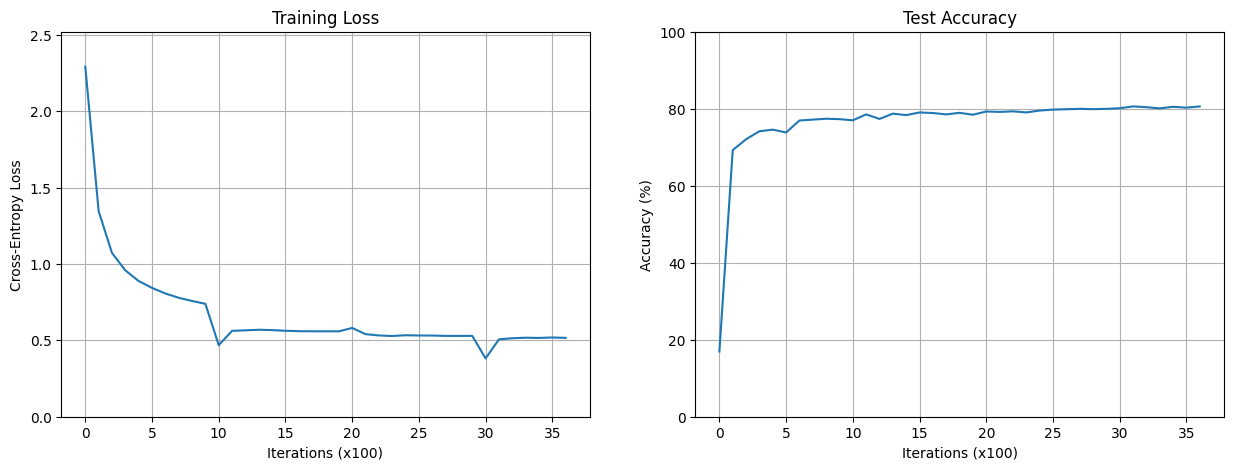

In [6]:
# Visualize Training Loss and Test Accuracy
print(f"Max test accuracy achieved: {max(test_accuracies):.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses)
ax1.set_title("Training Loss")
ax1.set_xlabel(f"Iterations (x{print_iter_interval})")
ax1.set_ylabel("Cross-Entropy Loss")
ax1.set_ylim(0, max(train_losses) * 1.1)  # Set y-axis limit to 10% above max loss
ax1.grid(True)

ax2.plot(test_accuracies)
ax2.set_title("Test Accuracy")
ax2.set_xlabel(f"Iterations (x{print_iter_interval})")
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(0, 100)
ax2.grid(True)

plt.show()

##### If everything works correctly, you will get an accuracy of around 78% at the end of epoch 1, and stop at around 80%.
---